In [25]:
import pandas as pd
from pprint import pprint
import glob
import pandas as pd
pd.set_option('display.max_rows', None)

for model_type in ["dictionary", "biolord"]:
    output_folder = f"../exports/selected_reports_with_event_log_only_{model_type}"
    output_file = f"{output_folder}/combined.pkl"
    batch_files = sorted(glob.glob(f"{output_folder}/batch_*.pkl"))
    combined_df = pd.concat([pd.read_pickle(f) for f in batch_files], ignore_index=True)
    combined_df.to_pickle(output_file)

def prepare_df(df, type="biolord"):
    df = df.copy()
    df['Sent_ID'] = df['Events'].apply(lambda x: [i for i in range(len(x))])
    df = df.explode(["Sent_ID","Events"])
    df['Event_Name'] = df['Events'].apply(lambda x: x['event'])
    df['Sentence'] = df['Events'].apply(lambda x: x['sentence'])
    df['Time'] = df['Events'].apply(lambda x: x['event_detection_time'])
    
    if type == "dictionary":
        df['Keyword'] = df['Events'].apply(lambda x: x['keyword'])
    if type == "biolord":
        df['Similarity'] = df['Events'].apply(lambda x: x['similarity'])
        df['Similarity'] = df['Similarity'].apply(lambda x: {k:v for (k,v) in x.items() if k!="Alert And Oriented"})
        df["Sleep_similarity"] = df['Similarity'].apply(lambda x:x["Sleep"])
        df["Pain_similarity"] = df['Similarity'].apply(lambda x:x["Pain"])
        df["Excretion_similarity"] = df['Similarity'].apply(lambda x:x["Excretion"])
        df["Eating_similarity"] = df['Similarity'].apply(lambda x:x["Eating"])
        df["Family_similarity"] = df['Similarity'].apply(lambda x:x["Family"])
        # df["Alert And Oriented_similarity"] = df['Similarity'].apply(lambda x:x["Alert And Oriented"])
    return df
df_dictionary = prepare_df(pd.read_pickle("../exports/selected_reports_with_event_log_only_dictionary/combined.pkl"),type="dictionary")
df_biolord = prepare_df(pd.read_pickle("../exports/selected_reports_with_event_log_only_biolord/combined.pkl"), type = "biolord")



# pprint(df1.iloc[0].to_string())


In [26]:
# df_biolord.Similarity = df_biolord.Similarity.astype(str)
df_both = pd.merge(df_dictionary[['ROW_ID','Sent_ID','HADM_ID','CHARTTIME','STORETIME','Sentence','Event_Name','Keyword','CGID','Time']], 
         df_biolord[['ROW_ID','Sent_ID','HADM_ID','CHARTTIME','STORETIME','Sentence','Event_Name','CGID','Similarity','Eating_similarity', 'Excretion_similarity', 'Family_similarity', 'Pain_similarity', 'Sleep_similarity','Time']], 
         on=['HADM_ID','ROW_ID','Sent_ID'], how='outer',suffixes=("_dictionary","_biolord")).sort_values(by=['HADM_ID','ROW_ID','Sent_ID'])

In [36]:
df_both.columns, df_both.Event_Name_dictionary.value_counts()

(Index(['ROW_ID', 'Sent_ID', 'HADM_ID', 'CHARTTIME_dictionary',
        'STORETIME_dictionary', 'Sentence_dictionary', 'Event_Name_dictionary',
        'Keyword', 'CGID_dictionary', 'Time_dictionary', 'CHARTTIME_biolord',
        'STORETIME_biolord', 'Sentence_biolord', 'Event_Name_biolord',
        'CGID_biolord', 'Similarity', 'Eating_similarity',
        'Excretion_similarity', 'Family_similarity', 'Pain_similarity',
        'Sleep_similarity', 'Time_biolord', 'only_Pain', 'contains_Pain',
        'no_Pain', 'disagreement_only_Pain_th_0_2',
        'disagreement_no_Pain_th_0_2', 'disagreement_unknown_th_0_2',
        'disagreement_multi_th_0_2', 'only_Sleep', 'contains_Sleep', 'no_Sleep',
        'disagreement_only_Sleep_th_0_2', 'disagreement_no_Sleep_th_0_2',
        'only_Excretion', 'contains_Excretion', 'no_Excretion',
        'disagreement_only_Excretion_th_0_2',
        'disagreement_no_Excretion_th_0_2', 'only_Eating', 'contains_Eating',
        'no_Eating', 'disagreement_on

Pain
Pain 541 95 0


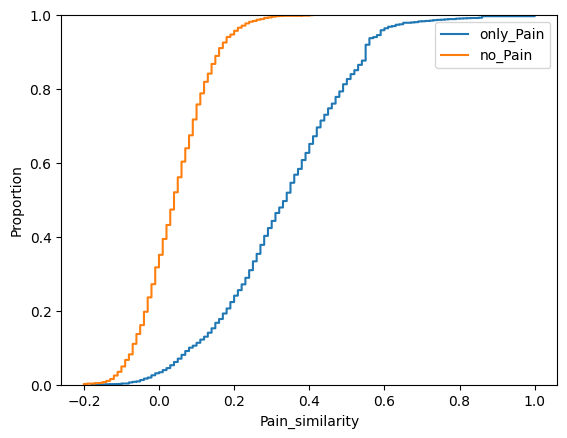

Sleep
Sleep 68 1019 0


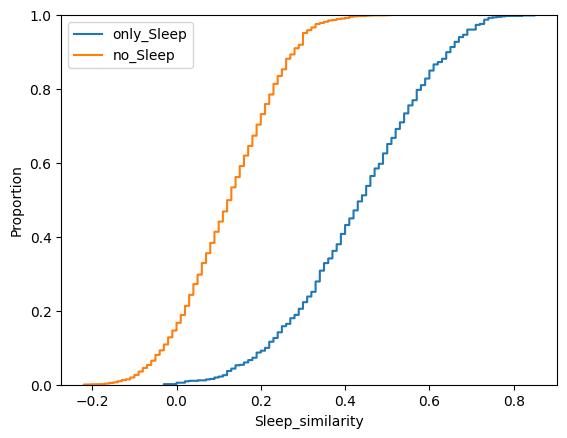

Excretion
Excretion 110 60 0


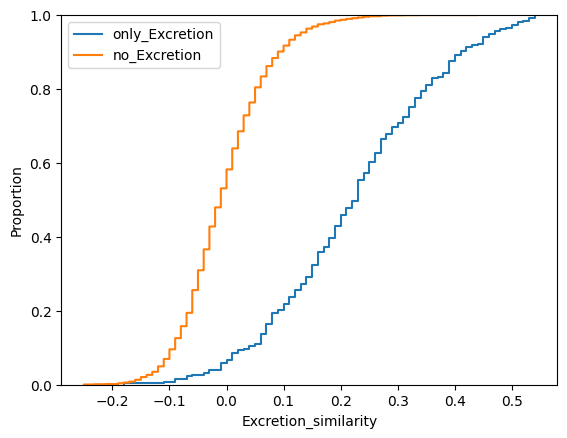

Eating
Eating 110 450 0


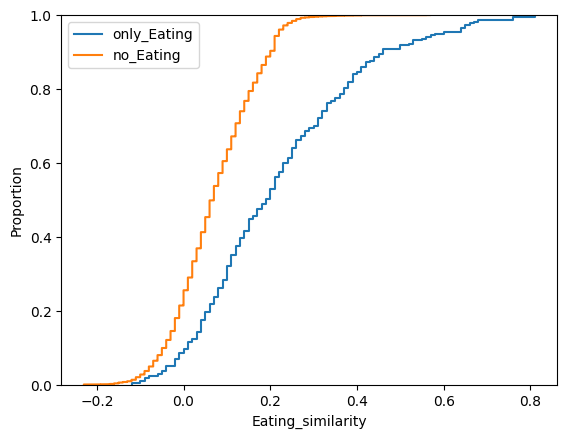

Family
Family 209 8 0


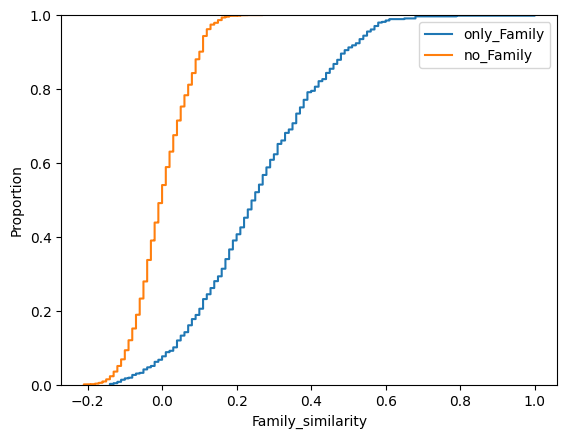

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_ecdf(sample, label=None):
    if len(sample) > 0:
        sns.ecdfplot(sample, label=label)
        if label:
            plt.legend()
        
        
event_types = ["Pain", "Sleep", "Excretion", "Eating", "Family"]


disagreement_1_list = []
disagreement_2_list = []
for selected_event_type in event_types:
    print(selected_event_type)
    for threshold in ["0_2"]:
        th = float(threshold.replace("_","."))
        df_both[f'only_{selected_event_type}'] = df_both["Event_Name_dictionary"].apply(lambda x: True if (selected_event_type in set(x) and len(set(x)) == 1) else False)
        df_both[f'contains_{selected_event_type}'] = df_both["Event_Name_dictionary"].apply(lambda x: True if (selected_event_type in set(x)) else False)
        df_both[f'no_{selected_event_type}'] = df_both["Event_Name_dictionary"].apply(lambda x: True if (selected_event_type not in set(x) and (len(set(x)) == 1) and  set(x).pop() in event_types) else False)
        df_both[f"disagreement_only_{selected_event_type}_th_{threshold}"] = df_both.apply(lambda x: True if (x[f'only_{selected_event_type}'] and x[f'{selected_event_type}_similarity']<th) else False, axis=1)
        df_both[f"disagreement_no_{selected_event_type}_th_{threshold}"] = df_both.apply(lambda x: True if (x[f'no_{selected_event_type}'] and x[f'{selected_event_type}_similarity']>=th) else False, axis=1)
        
        disagreement1 = df_both[df_both[f"disagreement_only_{selected_event_type}_th_0_2"]]
        disagreement2 = df_both[df_both[f"disagreement_no_{selected_event_type}_th_0_2"]]
        common_to_both_disagreement = df_both[df_both[f"disagreement_only_{selected_event_type}_th_0_2"] & df_both[f"disagreement_no_{selected_event_type}_th_0_2"]]
        print(selected_event_type, len(disagreement1), len(disagreement2), len(common_to_both_disagreement))
        plot_ecdf(df_both[df_both[f"only_{selected_event_type}"]][f"{selected_event_type}_similarity"], label=f"only_{selected_event_type}")
        plot_ecdf(df_both[df_both[f"no_{selected_event_type}"]][f"{selected_event_type}_similarity"], label=f"no_{selected_event_type}")
        plt.show()
        disagreement_1_list.append(disagreement1)
        disagreement_2_list.append(disagreement2)
        
    df_both[f"disagreement_unknown_th_{threshold}"] = df_both.apply(lambda x: True if (x[f'Event_Name_dictionary']=="Unknown" and any([x[f'{selected_event_type}_similarity']>=th for selected_event_type in event_types])) else False, axis=1)
    df_both[f"disagreement_multi_th_{threshold}"] = df_both.apply(lambda x: True if (len(x[f'Event_Name_dictionary'])>1 and all([x[f'{selected_event_type}_similarity']<=th for selected_event_type in event_types])) else False, axis=1)
    disagreement1_df = pd.concat(disagreement_1_list)    
    disagreement2_df = pd.concat(disagreement_2_list) 
    disagreement3_df = df_both[df_both[f"disagreement_unknown_th_{threshold}"]]
    disagreement4_df = df_both[df_both[f"disagreement_multi_th_{threshold}"]]

In [41]:
print(len(disagreement2_df))
disagreement2_df['Event_Name_dictionary_set'] = disagreement2_df['Event_Name_dictionary'].apply(lambda x: "_".join(sorted(list(set(x)))))
def stratified_sample_df(df, col):
    # Get the size of the smallest group
    min_count = df[col].value_counts().min()

    # Sample min_count rows from each group
    samples = (
        df.groupby(col)
        .apply(lambda x: x.sample(n=min_count, random_state=1))
        .reset_index(drop=True)
    )

    return samples

disagreement2_df_startified = stratified_sample_df(disagreement2_df,"Event_Name_dictionary_set")

1632


/tmp/ipykernel_843854/1139866455.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_count, random_state=1))


In [42]:
disagreement2_df.Event_Name_dictionary_set.value_counts(), disagreement2_df_startified.Event_Name_dictionary_set.value_counts()

(Event_Name_dictionary_set
 Pain         1296
 Sleep         179
 Family         99
 Eating         48
 Excretion      10
 Name: count, dtype: int64,
 Event_Name_dictionary_set
 Eating       10
 Excretion    10
 Family       10
 Pain         10
 Sleep        10
 Name: count, dtype: int64)

In [44]:
len(disagreement1_df)

1038

In [4]:
import pandas as pd
import os, sys
from datetime import datetime

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from utils.event_extractor import EventExtractor

def extract_events(sentences, extractor, evidence={'keywords':[],'event_names':[],'similarities':[]}):
    event_types = ["Pain", "Sleep", "Excretion", "Eating", "Family"]
    events = extractor.extract_events(sentences=sentences, event_names=event_types, threshold=0.2, prompt_evidence=evidence)
    return events




/home/asusaiyah/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
os.makedirs("../exports/disagreements", exist_ok=True)
for file_name,disagreement_df_temp in {"only_event_mention":disagreement1_df.copy().iloc[:1], 
                                  "no_particular_event_mention":disagreement2_df.copy().iloc[:1],
                                  "unknown_event":disagreement3_df.copy().iloc[:1],
                                  "multi_event":disagreement4_df.copy().iloc[:1]}.items():
    print(file_name, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    disagreement_df_temp['Keyword_set'] = disagreement_df_temp['Keyword'].apply(lambda x: list(set(x)))
    disagreement_df_temp['Event_set'] = disagreement_df_temp['Event_Name_dictionary'].apply(lambda x: list(set(x))[0])
    disagreement_df_temp["LLM_Events_no_evidence"] = extract_events(disagreement_df_temp.Sentence_dictionary, 
                                                        EventExtractor(event_name_model_type="llama3", attribute_model_type="None"))
    disagreement_df_temp["LLM_Events_dict_evidence"] = extract_events(disagreement_df_temp.Sentence_dictionary, 
                                                        EventExtractor(event_name_model_type="llama3", attribute_model_type="None"),
                                                        evidence={'keywords':disagreement_df_temp.Keyword_set.tolist(), 
                                                                        'event_names':disagreement_df_temp.Event_set.tolist(), 
                                                                        'similarities':[]})
    disagreement_df_temp["LLM_Events_embedder_evidence"] = extract_events(disagreement_df_temp.Sentence_dictionary, 
                                                        EventExtractor(event_name_model_type="llama3", attribute_model_type="None"),
                                                        evidence={'keywords':[], 
                                                                        'event_names':[], 
                                                                        'similarities':disagreement_df_temp.Similarity.tolist()})
    disagreement_df_temp["LLM_Events_all_evidence"] = extract_events(disagreement_df_temp.Sentence_dictionary, 
                                                        EventExtractor(event_name_model_type="llama3", attribute_model_type="None"),
                                                        evidence={'keywords':disagreement_df_temp.Keyword_set.tolist(), 
                                                                        'event_names':disagreement_df_temp.Event_set.tolist(), 
                                                                        'similarities':disagreement_df_temp.Similarity.tolist()})
    disagreement_df_temp['Event_Name_LLM_Events_no_evidence'] = disagreement_df_temp['LLM_Events_no_evidence'].apply(lambda x: x['event'])
    disagreement_df_temp['Event_Name_LLM_Events_dict_evidence'] = disagreement_df_temp['LLM_Events_dict_evidence'].apply(lambda x: x['event'])
    disagreement_df_temp['Event_Name_LLM_Events_embedder_evidence'] = disagreement_df_temp['LLM_Events_embedder_evidence'].apply(lambda x: x['event'])
    disagreement_df_temp['Event_Name_LLM_Events_all_evidence'] = disagreement_df_temp['LLM_Events_all_evidence'].apply(lambda x: x['event'])
    disagreement_df_temp.to_pickle(f"../exports/disagreements/{file_name}.pkl")
    

In [6]:
disagreement_df_temp[['Event_Name_dictionary','Event_Name_biolord','Event_Name_LLM_Events_no_evidence','Event_Name_LLM_Events_dict_evidence','Event_Name_LLM_Events_embedder_evidence','Event_Name_LLM_Events_all_evidence']]

,Event_Name_dictionary,Event_Name_biolord,Event_Name_LLM_Events_no_evidence,Event_Name_LLM_Events_dict_evidence,Event_Name_LLM_Events_embedder_evidence,Event_Name_LLM_Events_all_evidence
153,"[Alert and Oriented, Alert and Oriented]",Alert And Oriented,Unknown,Unknown,Unknown,Unknown


In [7]:
disagreement_df_temp["LLM_Events_all_evidence"].iloc[0]

{'sentence': "csru nppn 11p-7a\ns/[**name (ni) **] patient alert and oriented, mentating well, mae's w/in limits of iabp.\ncon't on iabp 1:1 most of noc, svo2 63-68% with ci 1.8-2.2, cvp 16-20 and pap's 36/18- 44/24",
 'event': 'Unknown',
 'attributes': {},
 'event_name_prompt': 'Given the sentence: csru nppn 11p-7a\ns/[**name (ni) **] patient alert and oriented, mentating well, mae\'s w/in limits of iabp.\ncon\'t on iabp 1:1 most of noc, svo2 63-68% with ci 1.8-2.2, cvp 16-20 and pap\'s 36/18- 44/24. \n                and the following event types: [\'Pain\', \'Sleep\', \'Excretion\', \'Eating\', \'Family\', \'Unknown\']\n                choose the most relevant event type(s) for this sentence.\n                choose "Unknown" if none of the other event type are applicable.\n                Additional facts:\n            A keyword matching algorithm without context, detected keyword(s): [\'oriented\', \'alert\']\n            and assigned event type: Alert and Oriented\n            A 